# Jet Energy Reolution for separately central jet and forward jet
## For N1 900 GeV ; gl 1000 GeV ; 10k events ; using CKKW

Notes: 

1. Calculates the distance(in terms of deltaR) between each jet and gen jet in terms of eta and phi
2. Finds the closest gen jet to each jet based on the calculated distance
3. Add an upper cut(deltaR is below 0.4) to avoid issues just to avoid fat tails in the resolution
4. Calculates the ratio of Jet.PT to GenJet.PT for each pair of jet and gen jet for each of the event
5. For RMSE, define some pT binning, group the jets according to that, calculate the RMSE of the ratio separately for each bin using jets belonging to that bin
6. Draw 2D plot between PT_Jet and RMSE(ratio)

--> Jet.PT is using instead of Jet.Energy

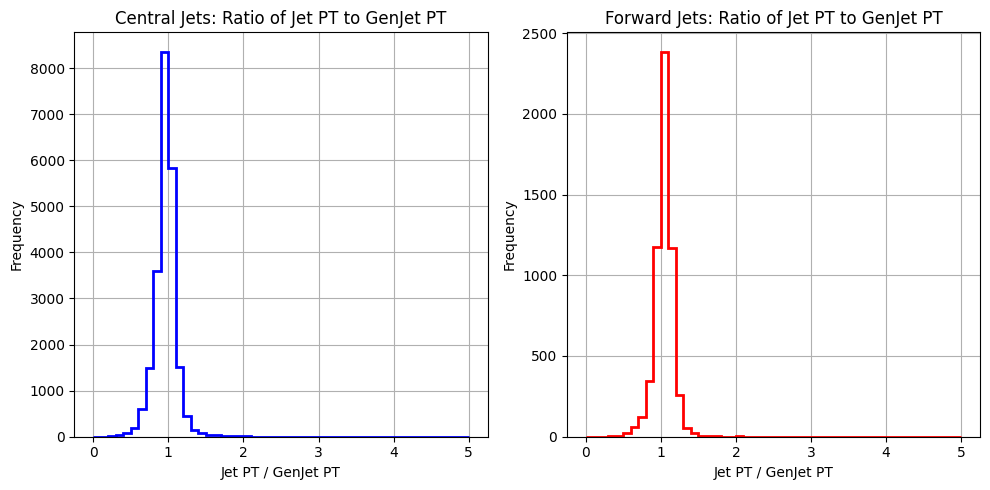

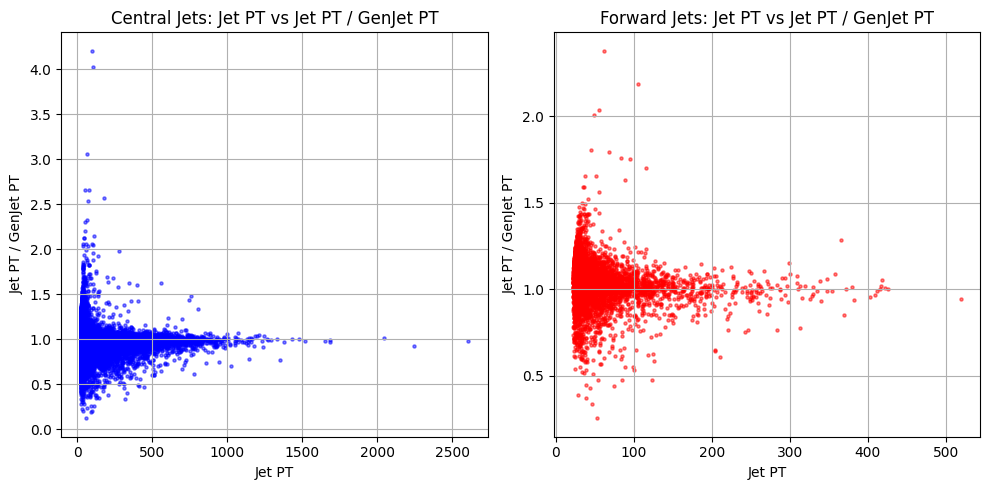

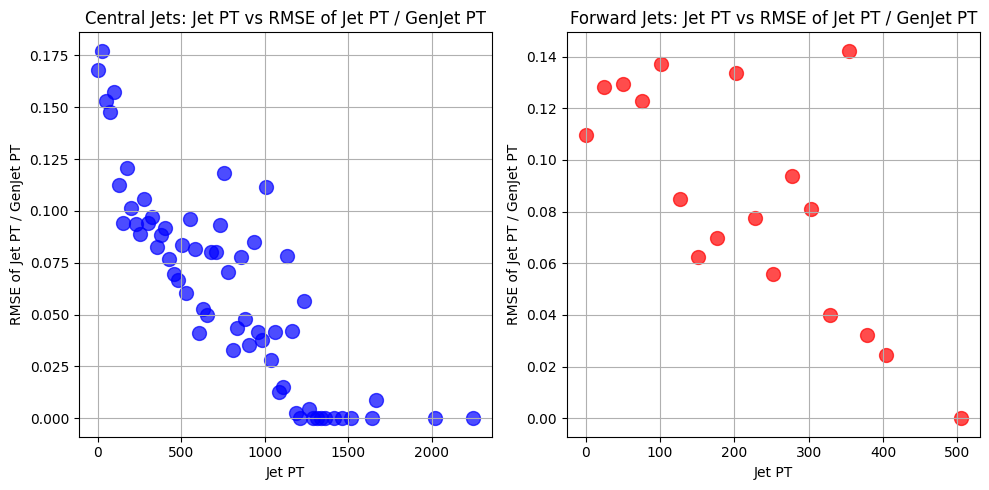

In [29]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

# Set the path to the ROOT file
home_dir = "root_files/N900/"
inputFile = home_dir + "tag_1_delphes_events.root"

# Create chain of root trees
chain = ROOT.TChain("Delphes")
chain.Add(inputFile)

# Create object of class ExRootTreeReader
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

# Get pointers to the branches containing Jet and GenJet information
branchJet = treeReader.UseBranch("Jet")
branchGenJet = treeReader.UseBranch("GenJet")

# Lists to store Jet PT and corresponding ratios for both central jets and forward jets
central_jet_pts = []
central_ratios = []
forward_jet_pts = []
forward_ratios = []

pt_bins = np.linspace(0, 2500, 100)  # 100 bins from 0 to 2500 GeV

# Lists to store RMSE for each pT bin
central_ratios_rmse_bins = []
forward_ratios_rmse_bins = []

# Loop over all events
for entry in range(numberOfEntries):
    # Load selected branches with data from specified event
    treeReader.ReadEntry(entry)
    
    num_jets = branchJet.GetEntries()
    num_gen_jets = branchGenJet.GetEntries()
    
    # Lists to store Jet PT and corresponding ratios for central jets and forward jets in current event
    central_jet_pts_event = []
    central_ratios_event = []
    forward_jet_pts_event = []
    forward_ratios_event = []
    
    # Loop over each jet and its corresponding gen jet
    for i in range(num_jets):
        jet = branchJet.At(i)
        
        # Find the closest gen jet to the jet in terms of deltaR
        closest_gen_jet = None
        min_delta_r = 999999.0
        
        for j in range(num_gen_jets):
            gen_jet = branchGenJet.At(j)
            
            delta_eta = jet.Eta - gen_jet.Eta
            delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
            delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
            if delta_r < 0.4:
                if delta_r < min_delta_r:
                    min_delta_r = delta_r
                    closest_gen_jet = gen_jet
                
        # Calculate the ratio of Jet.PT to GenJet.PT
        if closest_gen_jet:
            jet_pt_ratio = jet.PT / closest_gen_jet.PT
            if abs(jet.Eta) < 2.4:                          # Central jets: |eta| < 2.4
                central_jet_pts_event.append(jet.PT)
                central_ratios_event.append(jet_pt_ratio)
            else:                                           # Forward jets: |eta| >= 2.4
                forward_jet_pts_event.append(jet.PT)
                forward_ratios_event.append(jet_pt_ratio)
                
    # End event loop, extend main lists
    central_jet_pts.extend(central_jet_pts_event)
    central_ratios.extend(central_ratios_event)
    forward_jet_pts.extend(forward_jet_pts_event)
    forward_ratios.extend(forward_ratios_event)

# Convert lists to numpy arrays for plotting
central_jet_pts = np.array(central_jet_pts)
central_ratios = np.array(central_ratios)
forward_jet_pts = np.array(forward_jet_pts)
forward_ratios = np.array(forward_ratios)

# Calculate RMSE of ratios while passing all jets which gives constant

# central_ratios_rmse = np.std(central_ratios)
# forward_ratios_rmse = np.std(central_ratios)

# Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
for i in range(len(pt_bins) - 1):
    # Select jets within the current pT bin
    central_jet_pts_bin = central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
    central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
    forward_jet_pts_bin = forward_jet_pts[(forward_jet_pts >= pt_bins[i]) & (forward_jet_pts < pt_bins[i + 1])]
    forward_ratios_bin = forward_ratios[(forward_jet_pts >= pt_bins[i]) & (forward_jet_pts < pt_bins[i + 1])]
    
    # Calculate RMSE for central jets
    central_ratios_rmse_bin = np.std(central_ratios_bin)
    central_ratios_rmse_bins.append(central_ratios_rmse_bin)
    
    # Calculate RMSE for forward jets
    forward_ratios_rmse_bin = np.std(forward_ratios_bin)
    forward_ratios_rmse_bins.append(forward_ratios_rmse_bin)

# Plotting

# Jet PT to GenJet PT ratios
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(central_ratios, bins=50, range=(0, 5), histtype='step', color='blue', linewidth=2)
plt.xlabel('Jet PT / GenJet PT')
plt.ylabel('Frequency')
plt.title('Central Jets: Ratio of Jet PT to GenJet PT')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(forward_ratios, bins=50, range=(0, 5), histtype='step', color='red', linewidth=2)
plt.xlabel('Jet PT / GenJet PT')
plt.ylabel('Frequency')
plt.title('Forward Jets: Ratio of Jet PT to GenJet PT')
plt.grid(True)

plt.tight_layout()
plt.show()

# # RMSE of Jet PT to GenJet PT ratios
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.hist(central_ratios_rmse, bins=50, range=(0, 5), histtype='step', color='blue', linewidth=2)
# plt.xlabel('RMSE(Jet PT / GenJet PT)')
# plt.ylabel('')
# plt.title('Central Jets: RMSE Ratio of Jet PT to GenJet PT')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.hist(forward_ratios_rmse, bins=50, range=(0, 5), histtype='step', color='red', linewidth=2)
# plt.xlabel('RMSE(Jet PT / GenJet PT)')
# plt.ylabel('')
# plt.title('Forward Jets: RMSE Ratio of Jet PT to GenJet PT')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# 2D plot of Jet PT vs ratio
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(central_jet_pts, central_ratios, s=5, c='blue', alpha=0.5)
plt.xlabel('Jet PT')
plt.ylabel('Jet PT / GenJet PT')
plt.title('Central Jets: Jet PT vs Jet PT / GenJet PT')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(forward_jet_pts, forward_ratios, s=5, c='red', alpha=0.5)
plt.xlabel('Jet PT')
plt.ylabel('Jet PT / GenJet PT')
plt.title('Forward Jets: Jet PT vs Jet PT / GenJet PT')
plt.grid(True)

plt.tight_layout()
plt.show()

# RMSE Separate

plt.figure(figsize=(10, 5))

# Central jets plot
plt.subplot(1, 2, 1)
plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7)
plt.xlabel('Jet PT')
plt.ylabel('RMSE of Jet PT / GenJet PT')
plt.title('Central Jets: Jet PT vs RMSE of Jet PT / GenJet PT')
plt.grid(True)

# Forward jets plot
plt.subplot(1, 2, 2)
plt.scatter(pt_bins[:-1], forward_ratios_rmse_bins, s=100, c='red', alpha=0.7)
plt.xlabel('Jet PT')
plt.ylabel('RMSE of Jet PT / GenJet PT')
plt.title('Forward Jets: Jet PT vs RMSE of Jet PT / GenJet PT')
plt.grid(True)

plt.tight_layout()
plt.show()

# RMSE same Canvas
# plt.figure(figsize=(10, 5))

# plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', label='Central Jets', alpha=0.7)
# plt.scatter(pt_bins[:-1], forward_ratios_rmse_bins, s=100, c='red', label='Forward Jets', alpha=0.7)

# plt.xlabel('Jet PT')
# plt.ylabel('RMSE of Jet PT / GenJet PT')
# plt.title('Jet PT vs RMSE of Jet PT / GenJet PT')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

%reset -f
